In [1]:
# Cell 1: Initial Setup, Library Imports, and Data Loading

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib # For saving/loading models
import os # For path handling

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder # Need LabelEncoder for XGBoost
from sklearn.impute import SimpleImputer # For handling NaNs from rolling averages
from sklearn.pipeline import Pipeline # Use standard sklearn Pipeline

# Import Evaluation Metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, log_loss

# Import XGBoost
from xgboost import XGBClassifier

from scipy.stats import randint, uniform # For tuning parameter distributions

import warnings
warnings.filterwarnings('ignore', category=UserWarning) # Suppress UserWarnings from XGBoost
warnings.filterwarnings('ignore', category=FutureWarning) # Suppress FutureWarnings
warnings.filterwarnings('ignore', message='No positive class found') # Suppress classification report warnings
warnings.filterwarnings('ignore', message='The use of label encoder in XGBClassifier is deprecated') # Suppress this specific warning


# Set aesthetic style for plots
sns.set_style('whitegrid')

print("Libraries imported and basic setup complete.")

# Load the dataset using your specified path
DATA_PATH = "../dataset/EPL_2018-2025.csv"
try:
    df = pd.read_csv(DATA_PATH)
    print(f"Data loaded successfully from {DATA_PATH}")
except FileNotFoundError:
    print(f"Error: Data file not found at {DATA_PATH}")
    print("Please ensure the file exists at the correct relative path.")
    raise FileNotFoundError(f"Data file not found at {DATA_PATH}")

# Display DataFrame Info
print("\nDataFrame Info:")
df.info()

Libraries imported and basic setup complete.
Data loaded successfully from ../dataset/EPL_2018-2025.csv

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2630 entries, 0 to 2629
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Season             2630 non-null   object
 1   MatchDate          2630 non-null   object
 2   HomeTeam           2630 non-null   object
 3   AwayTeam           2630 non-null   object
 4   FullTimeHomeGoals  2630 non-null   int64 
 5   FullTimeAwayGoals  2630 non-null   int64 
 6   FullTimeResult     2630 non-null   object
 7   HalfTimeHomeGoals  2630 non-null   int64 
 8   HalfTimeAwayGoals  2630 non-null   int64 
 9   HalfTimeResult     2630 non-null   object
 10  HomeShots          2630 non-null   int64 
 11  AwayShots          2630 non-null   int64 
 12  HomeShotsOnTarget  2630 non-null   int64 
 13  AwayShotsOnTarget  2630 non-null   int64 
 14  HomeCorners    

In [2]:
# Cell 2: Handle MatchDate and Sort Data

print("Converting MatchDate to datetime and sorting data...")

df['MatchDate'] = pd.to_datetime(df['MatchDate'])

# Sort the DataFrame by date to ensure chronological order for time-based feature engineering
df = df.sort_values(by='MatchDate').reset_index(drop=True)

print("MatchDate converted and data sorted.")
print("\nDataFrame head after sorting:")
print(df[['Season', 'MatchDate', 'HomeTeam', 'AwayTeam']].head())

Converting MatchDate to datetime and sorting data...
MatchDate converted and data sorted.

DataFrame head after sorting:
    Season  MatchDate      HomeTeam        AwayTeam
0  2018/19 2018-08-10    Man United       Leicester
1  2018/19 2018-08-11   Bournemouth         Cardiff
2  2018/19 2018-08-11        Fulham  Crystal Palace
3  2018/19 2018-08-11  Huddersfield         Chelsea
4  2018/19 2018-08-11     Newcastle       Tottenham


In [3]:
# Cell 3: Implement Team Strength/Form Features (Rolling Averages)

print("Calculating team strength/form features (rolling averages)...")

# Define the window size for rolling averages
ROLLING_WINDOW = 5

# --- get_rolling_stats_refined function ---
def get_rolling_stats_refined(team, match_date, df_sorted, window_size, location_filter=None):
    required_cols = ['MatchDate', 'HomeTeam', 'AwayTeam', 'FullTimeResult',
                     'FullTimeHomeGoals', 'FullTimeAwayGoals',
                     'HomeShots', 'AwayShots', 'HomeShotsOnTarget', 'AwayShotsOnTarget',
                     'HomeCorners', 'AwayCorners', 'HomeFouls', 'AwayFouls',
                     'HomeYellowCards', 'AwayYellowCards', 'HomeRedCards', 'AwayRedCards']

    team_matches = df_sorted[df_sorted['MatchDate'] < match_date].copy()
    team_matches_filtered = team_matches[(team_matches['HomeTeam'] == team) | (team_matches['AwayTeam'] == team)]

    if location_filter == 'Home':
        team_matches_filtered = team_matches_filtered[team_matches_filtered['HomeTeam'] == team]
    elif location_filter == 'Away':
        team_matches_filtered = team_matches_filtered[team_matches_filtered['AwayTeam'] == team]

    recent_matches = team_matches_filtered.sort_values(by='MatchDate').tail(window_size)

    if recent_matches.empty:
        return {}

    stats = {}
    valid_matches_results = recent_matches.dropna(subset=['FullTimeResult', 'HomeTeam', 'AwayTeam'])

    if not valid_matches_results.empty:
         points = valid_matches_results.apply(lambda row:
             3 if (row['HomeTeam'] == team and row['FullTimeResult'] == 'H') or \
                  (row['AwayTeam'] == team and row['FullTimeResult'] == 'A') else \
             1 if row['FullTimeResult'] == 'D' else \
             0, axis=1)
         stats['Points'] = points.mean()
    else:
         stats['Points'] = np.nan


    valid_matches_goals = recent_matches.dropna(subset=['FullTimeHomeGoals', 'FullTimeAwayGoals'])
    if not valid_matches_goals.empty:
        stats['GoalsScored'] = valid_matches_goals.apply(lambda row: row['FullTimeHomeGoals'] if row['HomeTeam'] == team else row['FullTimeAwayGoals'], axis=1).mean()
        stats['GoalsConceded'] = valid_matches_goals.apply(lambda row: row['FullTimeAwayGoals'] if row['HomeTeam'] == team else row['FullTimeHomeGoals'], axis=1).mean()
    else:
        stats['GoalsScored'] = np.nan
        stats['GoalsConceded'] = np.nan


    for col in ['Shots', 'ShotsOnTarget', 'Corners', 'Fouls', 'YellowCards', 'RedCards']:
        home_col = f'Home{col}'
        away_col = f'Away{col}'
        if home_col in recent_matches.columns and away_col in recent_matches.columns:
             valid_matches_stat = recent_matches.dropna(subset=[home_col, away_col])
             if not valid_matches_stat.empty:
                stats[col] = valid_matches_stat.apply(lambda row: row[home_col] if row['HomeTeam'] == team else row[away_col], axis=1).mean()
             else:
                stats[col] = np.nan
        else:
             stats[col] = np.nan

    return stats

# Apply the rolling stat calculation row by row
try:
    from tqdm.notebook import tqdm
    tqdm.pandas()
    use_progress_bar = True
except ImportError:
    print("tqdm.notebook not found. Install with 'pip install tqdm' for progress bar.")
    use_progress_bar = False

rolling_stats_list = []

iterator = df.iterrows()
if use_progress_bar:
    iterator = tqdm(df.iterrows(), total=df.shape[0], desc=f"Calculating {ROLLING_WINDOW}-Match Rolling Stats")

for index, row in iterator:
    home_team = row['HomeTeam']
    away_team = row['AwayTeam']
    match_date = row['MatchDate']

    home_team_home_stats = get_rolling_stats_refined(home_team, match_date, df, ROLLING_WINDOW, location_filter='Home')
    home_team_overall_stats = get_rolling_stats_refined(home_team, match_date, df, ROLLING_WINDOW, location_filter=None)

    away_team_away_stats = get_rolling_stats_refined(away_team, match_date, df, ROLLING_WINDOW, location_filter='Away')
    away_team_overall_stats = get_rolling_stats_refined(away_team, match_date, df, ROLLING_WINDOW, location_filter=None)

    match_stats = {
        f'HomeAvgLast{ROLLING_WINDOW}_GoalsScored_Home': home_team_home_stats.get('GoalsScored', np.nan),
        f'HomeAvgLast{ROLLING_WINDOW}_GoalsConceded_Home': home_team_home_stats.get('GoalsConceded', np.nan),
        f'HomeAvgLast{ROLLING_WINDOW}_ShotsOnTarget_Home': home_team_home_stats.get('ShotsOnTarget', np.nan),
        f'HomeAvgLast{ROLLING_WINDOW}_Corners_Home': home_team_home_stats.get('Corners', np.nan),
        f'HomeAvgLast{ROLLING_WINDOW}_YellowCards_Home': home_team_home_stats.get('YellowCards', np.nan),
        f'HomeAvgLast{ROLLING_WINDOW}_Points_Home': home_team_home_stats.get('Points', np.nan),

        f'AwayAvgLast{ROLLING_WINDOW}_GoalsScored_Away': away_team_away_stats.get('GoalsScored', np.nan),
        f'AwayAvgLast{ROLLING_WINDOW}_GoalsConceded_Away': away_team_away_stats.get('GoalsConceded', np.nan),
        f'AwayAvgLast{ROLLING_WINDOW}_ShotsOnTarget_Away': away_team_away_stats.get('ShotsOnTarget', np.nan),
        f'AwayAvgLast{ROLLING_WINDOW}_Corners_Away': away_team_away_stats.get('Corners', np.nan),
        f'AwayAvgLast{ROLLING_WINDOW}_YellowCards_Away': away_team_away_stats.get('YellowCards', np.nan),
        f'AwayAvgLast{ROLLING_WINDOW}_Points_Away': away_team_away_stats.get('Points', np.nan),

        f'HomeAvgLast{ROLLING_WINDOW}_GoalsScored_Overall': home_team_overall_stats.get('GoalsScored', np.nan),
        f'HomeAvgLast{ROLLING_WINDOW}_GoalsConceded_Overall': home_team_overall_stats.get('GoalsConceded', np.nan),
        f'HomeAvgLast{ROLLING_WINDOW}_ShotsOnTarget_Overall': home_team_overall_stats.get('ShotsOnTarget', np.nan),
        f'HomeAvgLast{ROLLING_WINDOW}_Points_Overall': home_team_overall_stats.get('Points', np.nan),

        f'AwayAvgLast{ROLLING_WINDOW}_GoalsScored_Overall': away_team_overall_stats.get('GoalsScored', np.nan),
        f'AwayAvgLast{ROLLING_WINDOW}_GoalsConceded_Overall': away_team_overall_stats.get('GoalsConceded', np.nan),
        f'AwayAvgLast{ROLLING_WINDOW}_ShotsOnTarget_Overall': away_team_overall_stats.get('ShotsOnTarget', np.nan),
        f'AwayAvgLast{ROLLING_WINDOW}_Points_Overall': away_team_overall_stats.get('Points', np.nan),

        f'HomeAttack_vs_AwayDefense_{ROLLING_WINDOW}Avg': home_team_home_stats.get('GoalsScored', np.nan) - away_team_away_stats.get('GoalsConceded', np.nan),
        f'AwayAttack_vs_HomeDefense_{ROLLING_WINDOW}Avg': away_team_away_stats.get('GoalsScored', np.nan) - home_team_home_stats.get('GoalsConceded', np.nan),
    }
    rolling_stats_list.append(match_stats)

rolling_stats_df = pd.DataFrame(rolling_stats_list)
df = pd.merge(df, rolling_stats_df, left_index=True, right_index=True, how='left')

print(f"Rolling average features ({ROLLING_WINDOW} matches) created.")
print("\nDataFrame head with rolling average features:")
rolling_cols_display = [col for col in df.columns if f'AvgLast{ROLLING_WINDOW}' in col][:15]
print(df[['HomeTeam', 'AwayTeam', 'MatchDate'] + rolling_cols_display].head())

Calculating team strength/form features (rolling averages)...


Calculating 5-Match Rolling Stats:   0%|          | 0/2630 [00:00<?, ?it/s]

Rolling average features (5 matches) created.

DataFrame head with rolling average features:
       HomeTeam        AwayTeam  MatchDate  HomeAvgLast5_GoalsScored_Home  \
0    Man United       Leicester 2018-08-10                            NaN   
1   Bournemouth         Cardiff 2018-08-11                            NaN   
2        Fulham  Crystal Palace 2018-08-11                            NaN   
3  Huddersfield         Chelsea 2018-08-11                            NaN   
4     Newcastle       Tottenham 2018-08-11                            NaN   

   HomeAvgLast5_GoalsConceded_Home  HomeAvgLast5_ShotsOnTarget_Home  \
0                              NaN                              NaN   
1                              NaN                              NaN   
2                              NaN                              NaN   
3                              NaN                              NaN   
4                              NaN                              NaN   

   HomeAvgLast5_C

In [4]:
# Cell 4: Feature Selection and Handling Missing Values (Imputation)

print("Selecting features for PRE-MATCH prediction and handling missing values using Imputation...")

# Define the target variable
TARGET = 'FullTimeResult'
y = df[TARGET].copy()

# Define the features to use for PRE-MATCH prediction.
# These are ONLY the rolling average team form features.
rolling_avg_cols = [col for col in df.columns if f'AvgLast{ROLLING_WINDOW}' in col]

if not rolling_avg_cols:
    print("Error: No rolling average columns found. Please check previous cell (Cell 3).")
    raise ValueError("No valid rolling average features found.")

features = rolling_avg_cols
X = df[features].copy()

print("\nSelected Features (VALID FOR PRE-MATCH PREDICTION):")
print(features)
print("\nShape of X (features) BEFORE imputation:", X.shape)
print("Shape of y (target) BEFORE imputation:", y.shape)
print("\nNumber of NaNs per feature column BEFORE imputation:")
print(X.isnull().sum().sort_values(ascending=False).head(10))

# Imputation: Fit on ENTIRE feature set before splitting
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputer.fit(X)
X_imputed_array = imputer.transform(X)
X_imputed = pd.DataFrame(X_imputed_array, columns=X.columns, index=X.index)

print(f"\nNumber of rows after imputation: {len(X_imputed)}")
print(f"Number of NaNs per feature column AFTER imputation:")
print(X_imputed.isnull().sum().sum())

X = X_imputed

print("\nFinal shape of features (X):", X.shape)
print("Final shape of target (y):", y.shape)
print("\nFinal Features (X) Head after imputation:")
print(X.head())
print("\nValue counts of target (y) on data used:")
print(y.value_counts())

Selecting features for PRE-MATCH prediction and handling missing values using Imputation...

Selected Features (VALID FOR PRE-MATCH PREDICTION):
['HomeAvgLast5_GoalsScored_Home', 'HomeAvgLast5_GoalsConceded_Home', 'HomeAvgLast5_ShotsOnTarget_Home', 'HomeAvgLast5_Corners_Home', 'HomeAvgLast5_YellowCards_Home', 'HomeAvgLast5_Points_Home', 'AwayAvgLast5_GoalsScored_Away', 'AwayAvgLast5_GoalsConceded_Away', 'AwayAvgLast5_ShotsOnTarget_Away', 'AwayAvgLast5_Corners_Away', 'AwayAvgLast5_YellowCards_Away', 'AwayAvgLast5_Points_Away', 'HomeAvgLast5_GoalsScored_Overall', 'HomeAvgLast5_GoalsConceded_Overall', 'HomeAvgLast5_ShotsOnTarget_Overall', 'HomeAvgLast5_Points_Overall', 'AwayAvgLast5_GoalsScored_Overall', 'AwayAvgLast5_GoalsConceded_Overall', 'AwayAvgLast5_ShotsOnTarget_Overall', 'AwayAvgLast5_Points_Overall']

Shape of X (features) BEFORE imputation: (2630, 20)
Shape of y (target) BEFORE imputation: (2630,)

Number of NaNs per feature column BEFORE imputation:
HomeAvgLast5_GoalsScored_Hom

In [5]:
# Cell 5: Final Data Check Before Modeling

print("Final data check before modeling:")
print("\nFeatures (X) Info:")
X.info()
print("\nTarget (y) Info:")
y.info()

Final data check before modeling:

Features (X) Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2630 entries, 0 to 2629
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   HomeAvgLast5_GoalsScored_Home       2630 non-null   float64
 1   HomeAvgLast5_GoalsConceded_Home     2630 non-null   float64
 2   HomeAvgLast5_ShotsOnTarget_Home     2630 non-null   float64
 3   HomeAvgLast5_Corners_Home           2630 non-null   float64
 4   HomeAvgLast5_YellowCards_Home       2630 non-null   float64
 5   HomeAvgLast5_Points_Home            2630 non-null   float64
 6   AwayAvgLast5_GoalsScored_Away       2630 non-null   float64
 7   AwayAvgLast5_GoalsConceded_Away     2630 non-null   float64
 8   AwayAvgLast5_ShotsOnTarget_Away     2630 non-null   float64
 9   AwayAvgLast5_Corners_Away           2630 non-null   float64
 10  AwayAvgLast5_YellowCards_Away       2630 non-null   fl

In [6]:
# Cell 6: Data Splitting (Chronological)

print("Splitting data chronologically...")

split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"Data split into {split_ratio*100}% train and {(1-split_ratio)*100}% test chronologically.")
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

print("\nDate range of Training Set:")
if not X_train.empty:
    print(f"  From: {df.loc[X_train.index[0], 'MatchDate'].date()}")
    print(f"  To:   {df.loc[X_train.index[-1], 'MatchDate'].date()}")
else:
    print("  Training set is empty.")

print("\nDate range of Testing Set:")
if not X_test.empty:
     print(f"  From: {df.loc[X_test.index[0], 'MatchDate'].date()}")
     print(f"  To:   {df.loc[X_test.index[-1], 'MatchDate'].date()}")
else:
    print("  Testing set is empty.")

Splitting data chronologically...
Data split into 80.0% train and 19.999999999999996% test chronologically.
Training data shape: (2104, 20)
Testing data shape: (526, 20)

Date range of Training Set:
  From: 2018-08-10
  To:   2024-01-20

Date range of Testing Set:
  From: 2024-01-20
  To:   2025-05-05


In [7]:
# Cell 7: Encode Target Variable (y) to Integers

print("Encoding target variable (y) to integers for XGBoost...")

label_encoder = LabelEncoder()

# Fit on the *entire* target variable to know all classes
label_encoder.fit(y)

# Transform train and test
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

print(f"Original y_train head: {y_train.head().tolist()}")
print(f"Encoded y_train head:  {y_train_encoded[:5].tolist()}")
print(f"Original y_test head:  {y_test.head().tolist()}")
print(f"Encoded y_test head:   {y_test_encoded[:5].tolist()}")

print("\nClass mapping:")
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

original_classes_order = label_encoder.classes_

print("Target variable encoded.")

Encoding target variable (y) to integers for XGBoost...
Original y_train head: ['H', 'H', 'A', 'A', 'A']
Encoded y_train head:  [2, 2, 0, 0, 0]
Original y_test head:  ['H', 'D', 'A', 'D', 'A']
Encoded y_test head:   [2, 1, 0, 1, 0]

Class mapping:
{'A': np.int64(0), 'D': np.int64(1), 'H': np.int64(2)}
Target variable encoded.


In [8]:
# Cell 8: Model Pipeline Definition (Scaler + XGBoost)

print("Defining the model pipeline (StandardScaler + XGBoost)...")

xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')

# Create the standard pipeline: Scaling -> Model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', xgb_model)
])

print("Standard Pipeline defined.")

Defining the model pipeline (StandardScaler + XGBoost)...
Standard Pipeline defined.


Training the base XGBoost model with scaling...
Base XGBoost model training complete.

Evaluating the base XGBoost model on the test set...

Base XGBoost Accuracy: 0.4696

Base XGBoost Confusion Matrix:


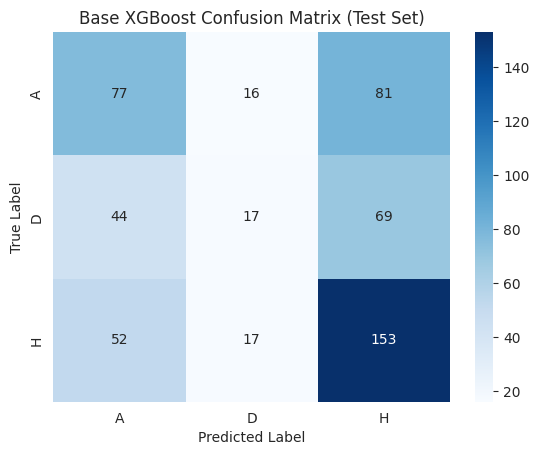


Base XGBoost Classification Report:
              precision    recall  f1-score   support

           A       0.45      0.44      0.44       174
           D       0.34      0.13      0.19       130
           H       0.50      0.69      0.58       222

    accuracy                           0.47       526
   macro avg       0.43      0.42      0.41       526
weighted avg       0.44      0.47      0.44       526


Base XGBoost Log Loss: 1.3100


In [9]:
# Cell 9: Base XGBoost Training and Evaluation

print("Training the base XGBoost model with scaling...")

pipeline.fit(X_train, y_train_encoded) # Use y_train_encoded

print("Base XGBoost model training complete.")

print("\nEvaluating the base XGBoost model on the test set...")

y_pred_base_xgb_encoded = pipeline.predict(X_test)
y_pred_proba_base_xgb = pipeline.predict_proba(X_test)

# Decode predictions for evaluation metrics that need string labels
y_pred_base_xgb_decoded = label_encoder.inverse_transform(y_pred_base_xgb_encoded)

# Evaluate Metrics
accuracy_base_xgb = accuracy_score(y_test, y_pred_base_xgb_decoded)
conf_matrix_base_xgb = confusion_matrix(y_test, y_pred_base_xgb_decoded)
class_report_base_xgb = classification_report(y_test, y_pred_base_xgb_decoded, target_names=original_classes_order)

logloss_base_xgb = log_loss(y_test, y_pred_proba_base_xgb, labels=original_classes_order)


print(f"\nBase XGBoost Accuracy: {accuracy_base_xgb:.4f}")
print("\nBase XGBoost Confusion Matrix:")
sns.heatmap(conf_matrix_base_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=original_classes_order, yticklabels=original_classes_order)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Base XGBoost Confusion Matrix (Test Set)")
plt.show()


print("\nBase XGBoost Classification Report:")
print(class_report_base_xgb)

print(f"\nBase XGBoost Log Loss: {logloss_base_xgb:.4f}")

In [10]:
# Cell 10: Hyperparameter Tuning (RandomizedSearchCV for XGBoost)

print("Starting Hyperparameter Tuning using RandomizedSearchCV for XGBoost...")

param_distributions_xgb_tuned = {
    'classifier__n_estimators': randint(100, 800),
    'classifier__learning_rate': uniform(0.005, 0.3),
    'classifier__max_depth': randint(3, 15),
    'classifier__subsample': uniform(0.6, 0.4),
    'classifier__colsample_bytree': uniform(0.6, 0.4),
    'classifier__gamma': uniform(0, 0.5),
    'classifier__reg_lambda': uniform(0.5, 1.5),
    'classifier__reg_alpha': uniform(0, 0.5),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search_xgb = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions_xgb_tuned,
    n_iter=100,
    scoring='neg_log_loss',
    cv=cv,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    return_train_score=False
)

random_search_xgb.fit(X_train, y_train_encoded) # Use y_train_encoded


print("\nTuned XGBoost Hyperparameter tuning complete.")
print("\nBest parameters found for XGBoost:")
print(random_search_xgb.best_params_)
print(f"\nBest cross-validation score (Negative Log Loss): {random_search_xgb.best_score_:.4f}")

Starting Hyperparameter Tuning using RandomizedSearchCV for XGBoost...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END classifier__colsample_bytree=0.749816047538945, classifier__gamma=0.4753571532049581, classifier__learning_rate=0.22459818254342154, classifier__max_depth=7, classifier__n_estimators=714, classifier__reg_alpha=0.22291637642679557, classifier__reg_lambda=0.6499623737270044, classifier__subsample=0.7836995567863468; total time=   1.4s
[CV] END classifier__colsample_bytree=0.7334834444556088, classifier__gamma=0.07143340896097039, classifier__learning_rate=0.20026654188465587, classifier__max_depth=7, classifier__n_estimators=443, classifier__reg_alpha=0.41622132040021087, classifier__reg_lambda=0.8185086660174142, classifier__subsample=0.6727299868828402; total time=   1.1s
[CV] END classifier__colsample_bytree=0.9895022075365837, classifier__gamma=0.11638567021515211, classifier__learning_rate=0.03218193035984624, classifier__max_depth=5, classif

Getting the final tuned XGBoost model pipeline...
Final tuned XGBoost model pipeline ready.

Evaluating the FINAL tuned XGBoost model on the test set...

Final Tuned XGBoost Accuracy: 0.5076

Final Tuned XGBoost Confusion Matrix:


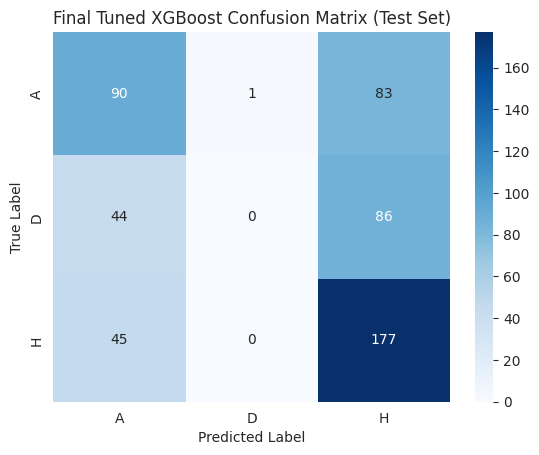


Final Tuned XGBoost Classification Report:
              precision    recall  f1-score   support

           A       0.50      0.52      0.51       174
           D       0.00      0.00      0.00       130
           H       0.51      0.80      0.62       222

    accuracy                           0.51       526
   macro avg       0.34      0.44      0.38       526
weighted avg       0.38      0.51      0.43       526


Final Tuned XGBoost Log Loss: 1.0091

Comparison:
Base XGBoost Accuracy: 0.4696 -> Final Tuned XGBoost Accuracy: 0.5076
Base XGBoost Log Loss: 1.3100 -> Final Tuned XGBoost Log Loss: 1.0091

Check Draw (D) predictions:
['', '    accuracy                           0.51       526', '   macro avg       0.34      0.44      0.38       526', 'weighted avg       0.38      0.51      0.43       526']


In [11]:
# Cell 11: Final XGBoost Model (Tuned) Training and Evaluation

print("Getting the final tuned XGBoost model pipeline...")

final_xgb_pipeline = random_search_xgb.best_estimator_

print("Final tuned XGBoost model pipeline ready.")


print("\nEvaluating the FINAL tuned XGBoost model on the test set...")

y_pred_final_xgb_encoded = final_xgb_pipeline.predict(X_test)
y_pred_proba_final_xgb = final_xgb_pipeline.predict_proba(X_test)

# Decode predictions for evaluation metrics
y_pred_final_xgb_decoded = label_encoder.inverse_transform(y_pred_final_xgb_encoded)

# Evaluate Metrics
accuracy_final_xgb = accuracy_score(y_test, y_pred_final_xgb_decoded)
conf_matrix_final_xgb = confusion_matrix(y_test, y_pred_final_xgb_decoded)
class_report_final_xgb = classification_report(y_test, y_pred_final_xgb_decoded, target_names=original_classes_order)

logloss_final_xgb = log_loss(y_test, y_pred_proba_final_xgb, labels=original_classes_order)


print(f"\nFinal Tuned XGBoost Accuracy: {accuracy_final_xgb:.4f}")
print("\nFinal Tuned XGBoost Confusion Matrix:")
sns.heatmap(conf_matrix_final_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=original_classes_order, yticklabels=original_classes_order)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Final Tuned XGBoost Confusion Matrix (Test Set)")
plt.show()

print("\nFinal Tuned XGBoost Classification Report:")
print(class_report_final_xgb)

print(f"\nFinal Tuned XGBoost Log Loss: {logloss_final_xgb:.4f}")

print("\nComparison:")
print(f"Base XGBoost Accuracy: {accuracy_base_xgb:.4f} -> Final Tuned XGBoost Accuracy: {accuracy_final_xgb:.4f}")
print(f"Base XGBoost Log Loss: {logloss_base_xgb:.4f} -> Final Tuned XGBoost Log Loss: {logloss_final_xgb:.4f}")

# Check Draw prediction metrics
print("\nCheck Draw (D) predictions:")
print(class_report_final_xgb.splitlines()[-4:]) # Print the D, H, macro, weighted rows

In [12]:
# Cell 12: Save Model and Preprocessors

print("Saving the final model pipeline, imputer, and label encoder...")

save_dir_final_xgb = 'model_assets_xgb' # Use a new directory name
os.makedirs(save_dir_final_xgb, exist_ok=True)

model_pipeline_path_final_xgb = os.path.join(save_dir_final_xgb, 'full_prediction_pipeline_xgb.joblib')
joblib.dump(final_xgb_pipeline, model_pipeline_path_final_xgb)

imputer_path_final_xgb = os.path.join(save_dir_final_xgb, 'imputer.joblib')
joblib.dump(imputer, imputer_path_final_xgb)

label_encoder_path_final_xgb = os.path.join(save_dir_final_xgb, 'label_encoder.joblib')
joblib.dump(label_encoder, label_encoder_path_final_xgb)


print(f"Final model pipeline saved to: {model_pipeline_path_final_xgb}")
print(f"Fitted Imputer saved to: {imputer_path_final_xgb}")
print(f"Fitted LabelEncoder saved to: {label_encoder_path_final_xgb}")
print("\nSaved assets can be loaded for prediction.")

Saving the final model pipeline, imputer, and label encoder...
Final model pipeline saved to: model_assets_xgb/full_prediction_pipeline_xgb.joblib
Fitted Imputer saved to: model_assets_xgb/imputer.joblib
Fitted LabelEncoder saved to: model_assets_xgb/label_encoder.joblib

Saved assets can be loaded for prediction.


In [13]:
# Cell 13: Design the Prediction Pipeline Function

print("Designing the prediction pipeline function...")

# Copy get_rolling_stats_refined function here for self-containment
def get_rolling_stats_refined(team, match_date, df_sorted, window_size, location_filter=None):
    required_cols = ['MatchDate', 'HomeTeam', 'AwayTeam', 'FullTimeResult',
                     'FullTimeHomeGoals', 'FullTimeAwayGoals',
                     'HomeShots', 'AwayShots', 'HomeShotsOnTarget', 'AwayShotsOnTarget',
                     'HomeCorners', 'AwayCorners', 'HomeFouls', 'AwayFouls',
                     'HomeYellowCards', 'AwayYellowCards', 'HomeRedCards', 'AwayRedCards']

    team_matches = df_sorted[df_sorted['MatchDate'] < match_date].copy()
    team_matches_filtered = team_matches[(team_matches['HomeTeam'] == team) | (team_matches['AwayTeam'] == team)]

    if location_filter == 'Home':
        team_matches_filtered = team_matches_filtered[team_matches_filtered['HomeTeam'] == team]
    elif location_filter == 'Away':
        team_matches_filtered = team_matches_filtered[team_matches_filtered['AwayTeam'] == team]

    recent_matches = team_matches_filtered.sort_values(by='MatchDate').tail(window_size)

    if recent_matches.empty:
        return {}

    stats = {}
    valid_matches_results = recent_matches.dropna(subset=['FullTimeResult', 'HomeTeam', 'AwayTeam'])

    if not valid_matches_results.empty:
         points = valid_matches_results.apply(lambda row:
             3 if (row['HomeTeam'] == team and row['FullTimeResult'] == 'H') or \
                  (row['AwayTeam'] == team and row['FullTimeResult'] == 'A') else \
             1 if row['FullTimeResult'] == 'D' else \
             0, axis=1)
         stats['Points'] = points.mean()
    else:
         stats['Points'] = np.nan


    valid_matches_goals = recent_matches.dropna(subset=['FullTimeHomeGoals', 'FullTimeAwayGoals'])
    if not valid_matches_goals.empty:
        stats['GoalsScored'] = valid_matches_goals.apply(lambda row: row['FullTimeHomeGoals'] if row['HomeTeam'] == team else row['FullTimeAwayGoals'], axis=1).mean()
        stats['GoalsConceded'] = valid_matches_goals.apply(lambda row: row['FullTimeAwayGoals'] if row['HomeTeam'] == team else row['FullTimeHomeGoals'], axis=1).mean()
    else:
        stats['GoalsScored'] = np.nan
        stats['GoalsConceded'] = np.nan


    for col in ['Shots', 'ShotsOnTarget', 'Corners', 'Fouls', 'YellowCards', 'RedCards']:
        home_col = f'Home{col}'
        away_col = f'Away{col}'
        if home_col in recent_matches.columns and away_col in recent_matches.columns:
             valid_matches_stat = recent_matches.dropna(subset=[home_col, away_col])
             if not valid_matches_stat.empty:
                stats[col] = valid_matches_stat.apply(lambda row: row[home_col] if row['HomeTeam'] == team else row[away_col], axis=1).mean()
             else:
                stats[col] = np.nan
        else:
             stats[col] = np.nan

    return stats

# Ensure ROLLING_WINDOW is defined
ROLLING_WINDOW = 5

# Define the path where assets were saved in Cell 12
save_dir_final_xgb = 'model_assets_xgb'
model_pipeline_path_final_xgb = os.path.join(save_dir_final_xgb, 'full_prediction_pipeline_xgb.joblib')
imputer_path_final_xgb = os.path.join(save_dir_final_xgb, 'imputer.joblib')
label_encoder_path_final_xgb = os.path.join(save_dir_final_xgb, 'label_encoder.joblib')

# Load the saved model and preprocessors
try:
    loaded_pipeline_final_xgb = joblib.load(model_pipeline_path_final_xgb)
    loaded_imputer_final_xgb = joblib.load(imputer_path_final_xgb)
    loaded_label_encoder_final_xgb = joblib.load(label_encoder_path_final_xgb)

    expected_features_final_xgb = list(loaded_pipeline_final_xgb.named_steps['scaler'].feature_names_in_)

    print("Model and preprocessors loaded successfully for prediction function.")
    print(f"Prediction function expects {len(expected_features_final_xgb)} features.")
    print(f"Model probability output order corresponds to classes: {loaded_label_encoder_final_xgb.classes_}")


except (FileNotFoundError, AttributeError) as e:
    print(f"Error loading model assets: {e}. Please ensure Cell 12 was run successfully.")
    loaded_pipeline_final_xgb = None
    loaded_imputer_final_xgb = None
    loaded_label_encoder_final_xgb = None
    expected_features_final_xgb = []


# --- The Prediction Function ---
def predict_epl_outcome(home_team, away_team, match_date_str, historical_df, model_pipeline, imputer, label_encoder, expected_features, window_size=5):
    """
    Predicts the outcome probabilities for a given EPL match using loaded assets.
    """
    if model_pipeline is None or imputer is None or label_encoder is None or not expected_features:
        print("Prediction failed: Model or preprocessors not loaded correctly.")
        return None

    try:
        match_date = pd.to_datetime(match_date_str)
    except ValueError:
        print(f"Error: Invalid match_date_str format: {match_date_str}. Use YYYY-MM-DD.")
        return None

    all_teams = pd.concat([historical_df['HomeTeam'], historical_df['AwayTeam']]).unique()
    if home_team not in all_teams or away_team not in all_teams:
        print(f"Error: One or both teams ('{home_team}', '{away_team}') not found in historical data.")
        return None

    # 1. Calculate rolling averages
    historical_df_sorted = historical_df.sort_values(by='MatchDate').reset_index(drop=True)
    home_stats = get_rolling_stats_refined(home_team, match_date, historical_df_sorted, window_size, location_filter='Home')
    home_stats_overall = get_rolling_stats_refined(home_team, match_date, historical_df_sorted, window_size, location_filter=None)
    away_stats = get_rolling_stats_refined(away_team, match_date, historical_df_sorted, window_size, location_filter='Away')
    away_stats_overall = get_rolling_stats_refined(away_team, match_date, historical_df_sorted, window_size, location_filter=None)

    home_attack_away_defense = home_stats.get('GoalsScored', np.nan) - away_stats.get('GoalsConceded', np.nan)
    away_attack_home_defense = away_stats.get('GoalsScored', np.nan) - home_stats.get('GoalsConceded', np.nan)

    # 2. Create feature DataFrame
    match_features_dict = {
        f'HomeAvgLast{window_size}_GoalsScored_Home': home_stats.get('GoalsScored', np.nan),
        f'HomeAvgLast{window_size}_GoalsConceded_Home': home_stats.get('GoalsConceded', np.nan),
        f'HomeAvgLast{window_size}_ShotsOnTarget_Home': home_stats.get('ShotsOnTarget', np.nan),
        f'HomeAvgLast{window_size}_Corners_Home': home_stats.get('Corners', np.nan),
        f'HomeAvgLast{window_size}_YellowCards_Home': home_stats.get('YellowCards', np.nan),
        f'HomeAvgLast{window_size}_Points_Home': home_stats.get('Points', np.nan),

        f'AwayAvgLast{window_size}_GoalsScored_Away': away_stats.get('GoalsScored', np.nan),
        f'AwayAvgLast{window_size}_GoalsConceded_Away': away_stats.get('GoalsConceded', np.nan),
        f'AwayAvgLast{window_size}_ShotsOnTarget_Away': away_stats.get('ShotsOnTarget', np.nan),
        f'AwayAvgLast{window_size}_Corners_Away': away_stats.get('Corners', np.nan),
        f'AwayAvgLast{window_size}_YellowCards_Away': away_stats.get('YellowCards', np.nan),
        f'AwayAvgLast{window_size}_Points_Away': away_stats.get('Points', np.nan),

        f'HomeAvgLast{window_size}_GoalsScored_Overall': home_stats_overall.get('GoalsScored', np.nan),
        f'HomeAvgLast{window_size}_GoalsConceded_Overall': home_stats_overall.get('GoalsConceded', np.nan),
        f'HomeAvgLast{window_size}_ShotsOnTarget_Overall': home_stats_overall.get('ShotsOnTarget', np.nan),
        f'HomeAvgLast{window_size}_Points_Overall': home_stats_overall.get('Points', np.nan),

        f'AwayAvgLast{window_size}_GoalsScored_Overall': away_stats_overall.get('GoalsScored', np.nan),
        f'AwayAvgLast{window_size}_GoalsConceded_Overall': away_stats_overall.get('GoalsConceded', np.nan),
        f'AwayAvgLast{window_size}_ShotsOnTarget_Overall': away_stats_overall.get('ShotsOnTarget', np.nan),
        f'AwayAvgLast{window_size}_Points_Overall': away_stats_overall.get('Points', np.nan),

        f'HomeAttack_vs_AwayDefense_{window_size}Avg': home_attack_away_defense,
        f'AwayAttack_vs_HomeDefense_{window_size}Avg': away_attack_home_defense,
    }

    X_new = pd.DataFrame([match_features_dict])
    X_new = X_new.reindex(columns=expected_features)

    # 3. Impute missing values
    X_new_imputed_array = imputer.transform(X_new)
    X_new_imputed = pd.DataFrame(X_new_imputed_array, columns=X_new.columns, index=X_new.index)

    # 4. Make the probability prediction
    # The pipeline handles scaling and prediction.
    prediction_proba_array = model_pipeline.predict_proba(X_new_imputed)

    # 5. Format the output
    # Use the loaded label_encoder to get original string labels in the correct order
    class_labels_order = label_encoder.classes_ # ['A', 'D', 'H']

    prediction_proba_dict = dict(zip(class_labels_order, prediction_proba_array[0]))

    return prediction_proba_dict

# --- Example Usage ---
if loaded_pipeline_final_xgb is not None and loaded_imputer_final_xgb is not None and loaded_label_encoder_final_xgb is not None and len(expected_features_final_xgb) > 0:

    print("\n--- Example Prediction ---")
    try:
        # Example from the test set
        first_test_match_index = X_test.index[0]
        first_test_match = df.loc[first_test_match_index]

        example_home_team = first_test_match['HomeTeam']
        example_away_team = first_test_match['AwayTeam']
        example_match_date_dt = pd.to_datetime(first_test_match['MatchDate']) # Ensure datetime
        example_match_date_str = example_match_date_dt.strftime('%Y-%m-%d')
        actual_result = first_test_match['FullTimeResult']

        print(f"Predicting match from test set: {example_home_team} vs {example_away_team} on {example_match_date_str}")

        predicted_probabilities = predict_epl_outcome(
            home_team=example_home_team,
            away_team=example_away_team,
            match_date_str=example_match_date_str,
            historical_df=df,
            model_pipeline=loaded_pipeline_final_xgb,
            imputer=loaded_imputer_final_xgb,
            label_encoder=loaded_label_encoder_final_xgb,
            expected_features=expected_features_final_xgb,
            window_size=ROLLING_WINDOW
        )

        if predicted_probabilities:
            print("\nPredicted Probabilities:")
            print(predicted_probabilities)
            predicted_outcome = max(predicted_probabilities, key=predicted_probabilities.get)
            print(f"Most likely outcome: {predicted_outcome}")
            print(f"Actual outcome: {actual_result}")
        else:
            print("Example prediction failed.")

        # Hypothetical future match
        latest_date_in_df = df['MatchDate'].max()
        future_date_dt = latest_date_in_df + pd.Timedelta(days=30)
        example_home_team_future = 'Man City'
        example_away_team_future = 'Arsenal'

        all_teams_in_df = pd.concat([df['HomeTeam'], df['AwayTeam']]).unique()
        if example_home_team_future in all_teams_in_df and example_away_team_future in all_teams_in_df:
            print(f"\nPredicting a hypothetical future match: {example_home_team_future} vs {example_away_team_future} on {future_date_dt.date()}")
            predicted_probabilities_future = predict_epl_outcome(
                home_team=example_home_team_future,
                away_team=example_away_team_future,
                match_date_str=future_date_dt.strftime('%Y-%m-%d'),
                historical_df=df,
                model_pipeline=loaded_pipeline_final_xgb,
                imputer=loaded_imputer_final_xgb,
                label_encoder=loaded_label_encoder_final_xgb,
                expected_features=expected_features_final_xgb,
                window_size=ROLLING_WINDOW
            )
            if predicted_probabilities_future:
                 print("\nHypothetical Predicted Probabilities:")
                 print(predicted_probabilities_future)
                 predicted_outcome_future = max(predicted_probabilities_future, key=predicted_probabilities_future.get)
                 print(f"Most likely hypothetical outcome: {predicted_outcome_future}")
        else:
             print(f"\nSkipping hypothetical future prediction: One or both teams ('{example_home_team_future}', '{example_away_team_future}') not found in historical data.")


    except NameError:
        print("\nError: X_test not found. Run Cell 6 to define X_test.")
        print("Cannot run example prediction.")


else:
    print("\nCannot run example prediction: Model, preprocessors, or feature list not loaded correctly.")

Designing the prediction pipeline function...
Model and preprocessors loaded successfully for prediction function.
Prediction function expects 20 features.
Model probability output order corresponds to classes: ['A' 'D' 'H']

--- Example Prediction ---
Predicting match from test set: Brentford vs Nott'm Forest on 2024-01-20

Predicted Probabilities:
{'A': np.float32(0.30734554), 'D': np.float32(0.24485467), 'H': np.float32(0.44779977)}
Most likely outcome: H
Actual outcome: H

Predicting a hypothetical future match: Man City vs Arsenal on 2025-06-04

Hypothetical Predicted Probabilities:
{'A': np.float32(0.32792115), 'D': np.float32(0.2591593), 'H': np.float32(0.4129195)}
Most likely hypothetical outcome: H
